## Create an artificial dataset

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
np.random.seed(520)

In [3]:
X_shape = (700, 1)

In [4]:
X = np.random.uniform(0.0, 20.0, X_shape)

In [5]:
def data_generator(X):
    # Some complex, heteroskedastic relation
    return 0.5*X + (X**2) * np.random.normal(0, 0.03, X.shape) + (X + 10) * np.random.normal(1, 0.2, X.shape) + np.random.normal(1, 2.5, X.shape) + 500

In [6]:
y = data_generator(X)

In [7]:
plt.scatter(X, y)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [9]:
X_proper_train, X_calibration, y_proper_train, y_calibration = train_test_split(X_train, y_train)

## Make a ridge conformal predictor

In [10]:
from sklearn.linear_model import RidgeCV

In [11]:
model = RidgeCV()

In [12]:
model.fit(X_proper_train, y_proper_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

In [13]:
x_line = np.linspace(X.min(), X.max()).reshape(-1, 1)

In [14]:
y_line = model.predict(x_line)

In [15]:
plt.plot(x_line, y_line, color='red')
plt.scatter(X, y)

In [16]:
def find_residual_buffer(model, significance, x_cal, y_cal):
    # Significance is (1 - coverage)
    y_pred = model.predict(x_cal).reshape((-1, 1))
    residuals = np.abs(y_pred - y_cal)
    return np.quantile(residuals, 1 - significance)

In [17]:
class ConformalRegressor:
    def __init__(self, model, significance):
        self._model = model
        self._significance = significance
        self._res_buf = None
    
    def fit(self, x_proper_train, y_proper_train, x_calibration, y_calibration):
        self._model.fit(x_proper_train, y_proper_train)
        self._res_buf = find_residual_buffer(self._model, self._significance, x_calibration, y_calibration)
    
    def predict(self, x):
        if self._res_buf is None:
            # should raise sth more fitting than value error, but whatever
            raise ValueError("Need to first fit the model")
        # Need to reshape for consistent outputs
        y_pred = self._model.predict(x).reshape((-1, 1))
        lower = y_pred - self._res_buf
        upper = y_pred + self._res_buf
        return lower, upper

In [18]:
model = ConformalRegressor(RidgeCV(), 0.10)

In [19]:
model.fit(X_proper_train, y_proper_train, X_calibration, y_calibration)

## Let's test the predictive sets

In [20]:
lower, upper = model.predict(X_test)

In [21]:
((y_test >= lower) & (y_test <= upper)).sum()/len(y_test)

0.9371428571428572

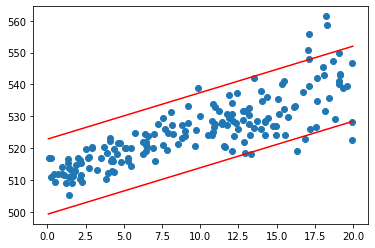

In [22]:
y_line_lower, y_line_upper = model.predict(x_line)
plt.plot(x_line, y_line_lower, color='red')
plt.plot(x_line, y_line_upper, color='red')
plt.scatter(X_test, y_test)

Ok so we wanted 90% of samples to be in the predictive set, and empirically we have ~90.2%.

Let's see how the empirical coverage varies as we test different data distributions.

In [23]:
from tqdm import tqdm
def sample_empirical_coverage(data_generator, data_size, samples, coverage_goal, model_object):
    vals = []
    for i in tqdm(range(samples)):
        X_shape = (data_size, 1)
        X = np.random.uniform(0.0, 20.0, X_shape)
        y = data_generator(X)
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        X_proper_train, X_calibration, y_proper_train, y_calibration = train_test_split(X_train, y_train)
        model = ConformalRegressor(model_object, 1 - coverage_goal)
        model.fit(X_proper_train, y_proper_train, X_calibration, y_calibration)
        lower, upper = model.predict(X_test)
        vals.append(((y_test >= lower) & (y_test <= upper)).sum()/len(y_test))
    return vals

100%|██████████| 5000/5000 [00:12<00:00, 413.69it/s]
<ipython-input-24-2ee87015f217>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


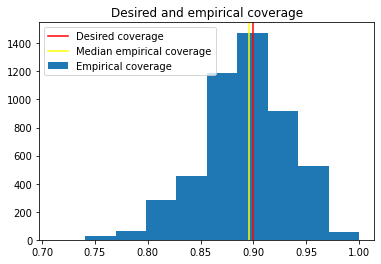

In [24]:
desired_cov = 0.9
empirical_cov_sample = sample_empirical_coverage(data_generator, 500, 5000, desired_cov, RidgeCV())

fig, ax = plt.subplots()
ax.hist(empirical_cov_sample, label='Empirical coverage')
ax.axvline(desired_cov, label='Desired coverage', color='red')
ax.axvline(np.median(empirical_cov_sample), label='Median empirical coverage', color='yellow')
ax.set_title("Desired and empirical coverage")
ax.legend()
fig.show()

##### 

## What about nonlinear models?

In [25]:
def nonlinear_data_generator(X):
    return -0.02 * (X ** 3) + 0.3 * (X ** 2) + 0.5 * X + ((-X + 10) ** 3) * np.random.normal(0, 0.02, X.shape) + (X + 10) * np.random.normal(1, 0.4, X.shape) + 30

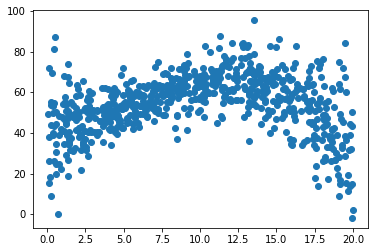

In [26]:
y = nonlinear_data_generator(X)
plt.scatter(X, y)

/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


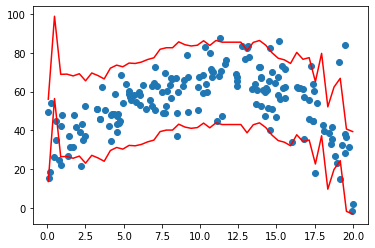

In [27]:
from sklearn.ensemble import GradientBoostingRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_proper_train, X_calibration, y_proper_train, y_calibration = train_test_split(X_train, y_train)

model = ConformalRegressor(GradientBoostingRegressor(), 0.10)
model.fit(X_proper_train, y_proper_train, X_calibration, y_calibration)

y_line_lower, y_line_upper = model.predict(x_line)
plt.plot(x_line, y_line_lower, color='red', label='Predictive interval')
plt.plot(x_line, y_line_upper, color='red')
plt.scatter(X_test, y_test)

In [28]:
nonlinear_data_generator(X).shape

(700, 1)

  0%|          | 0/500 [00:00<?, ?it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
  0%|          | 1/500 [00:00<00:56,  8.91it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
  0%|          | 2/500 [00:00<00:52,  9.49it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a

/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
  5%|▍         | 24/500 [00:02<00:39, 12.11it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example us

 10%|▉         | 48/500 [00:04<00:30, 14.68it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 10%|█         | 50/500 [00:04<00:30, 14.95it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

 14%|█▍        | 72/500 [00:05<00:29, 14.64it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 15%|█▍        | 74/500 [00:05<00:28, 14.81it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

 19%|█▉        | 96/500 [00:07<00:25, 15.94it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 20%|█▉        | 98/500 [00:07<00:25, 15.89it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 24%|██▍       | 120/500 [00:09<00:30, 12.66it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

 33%|███▎      | 166/500 [00:12<00:22, 15.14it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 34%|███▎      | 168/500 [00:12<00:21, 15.26it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 38%|███▊      | 190/500 [00:13<00:20, 15.17it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 47%|████▋     | 236/500 [00:17<00:20, 13.11it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 56%|█████▋    | 282/500 [00:20<00:14, 15.07it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 66%|██████▌   | 328/500 [00:23<00:14, 12.24it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

 75%|███████▍  | 374/500 [00:26<00:07, 16.83it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 75%|███████▌  | 376/500 [00:26<00:07, 15.85it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

 80%|███████▉  | 398/500 [00:28<00:07, 14.18it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 80%|████████  | 400/500 [00:28<00:06, 14.68it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 84%|████████▍ | 422/500 [00:29<00:05, 15.05it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 94%|█████████▎| 468/500 [00:33<00:02, 15.38it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

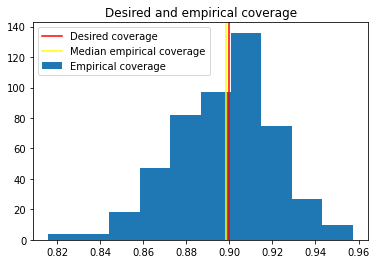

In [29]:
desired_cov = 0.9
empirical_cov_sample = sample_empirical_coverage(nonlinear_data_generator, 1500, 500, desired_cov, GradientBoostingRegressor())

fig, ax = plt.subplots()
ax.hist(empirical_cov_sample, label='Empirical coverage')
ax.axvline(desired_cov, label='Desired coverage', color='red')
ax.axvline(np.median(empirical_cov_sample), label='Median empirical coverage', color='yellow')
ax.set_title("Desired and empirical coverage")
ax.legend()
fig.show()

## Conformalized quantile regression

In [30]:
from sklearn.ensemble import GradientBoostingRegressor

def cqr_nonconformity(x, y, m_lo, m_up):
    lo = m_lo.predict(x).reshape((-1, 1))
    up = m_up.predict(x).reshape((-1, 1))
    return np.max((lo - y, y - up), axis=0)

def find_cqr_q(m_lo, m_up, significance, x_calibration, y_calibration):
    nonconformity = cqr_nonconformity(x_calibration, y_calibration, m_lo, m_up)
    return np.quantile(nonconformity, 1 - significance)

class ConformalizedQuantileRegressor:
    def __init__(self, significance):
        self._model_upper = GradientBoostingRegressor(loss='quantile', alpha=1 - significance/2)
        self._model_lower = GradientBoostingRegressor(loss='quantile', alpha=significance/2)
        self._significance = significance
        self._q = None
    
    def fit(self, x_proper_train, y_proper_train, x_calibration, y_calibration):
        self._model_upper.fit(x_proper_train, y_proper_train)
        self._model_lower.fit(x_proper_train, y_proper_train)
        self._q = find_cqr_q(self._model_lower, self._model_upper, self._significance, x_calibration, y_calibration)
    
    def predict(self, x):
        if self._q is None:
            # should raise sth more fitting than value error, but whatever
            raise ValueError("Need to first fit the model")
        # Need to reshape for consistent outputs
        y_pred_lo = self._model_lower.predict(x).reshape((-1, 1))
        y_pred_up = self._model_upper.predict(x).reshape((-1, 1))
        lower = y_pred_lo - self._q
        upper = y_pred_up + self._q
        return lower, upper

In [31]:
def sample_empirical_coverage_cqr(data_generator, data_size, samples, coverage_goal):
    vals = []
    for i in tqdm(range(samples)):
        X_shape = (data_size, 1)
        X = np.random.uniform(0.0, 20.0, X_shape)
        y = data_generator(X)
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        X_proper_train, X_calibration, y_proper_train, y_calibration = train_test_split(X_train, y_train)
        model = ConformalizedQuantileRegressor(1 - coverage_goal)
        model.fit(X_proper_train, y_proper_train, X_calibration, y_calibration)
        lower, upper = model.predict(X_test)
        vals.append(((y_test >= lower) & (y_test <= upper)).sum()/len(y_test))
    return vals

/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


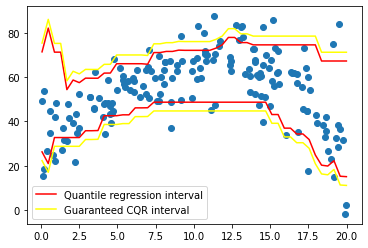

In [32]:
cqr = ConformalizedQuantileRegressor(0.1)
cqr.fit(X_proper_train, y_proper_train, X_calibration, y_calibration)

y_line_upper = cqr._model_upper.predict(x_line)
y_line_lower = cqr._model_lower.predict(x_line)
y_line_lower_cqr, y_line_upper_cqr = cqr.predict(x_line)

plt.plot(x_line, y_line_lower, color='red', label='Quantile regression interval')
plt.plot(x_line, y_line_upper, color='red')
plt.plot(x_line, y_line_lower_cqr, color='yellow', label='Guaranteed CQR interval')
plt.plot(x_line, y_line_upper_cqr, color='yellow')
plt.scatter(X_test, y_test)
plt.legend()

  0%|          | 0/500 [00:00<?, ?it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
  0%|          | 1/500 [00:00<04:41,  1.77it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

  2%|▏         | 12/500 [00:07<05:43,  1.42it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
  3%|▎         | 13/500 [00:08<05:35,  1.45it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

  5%|▍         | 24/500 [00:16<05:48,  1.37it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
  5%|▌         | 25/500 [00:17<06:02,  1.31it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

  7%|▋         | 36/500 [00:25<05:27,  1.42it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
  7%|▋         | 37/500 [00:25<05:26,  1.42it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

 10%|▉         | 48/500 [00:34<05:16,  1.43it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 10%|▉         | 49/500 [00:35<05:25,  1.38it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

 12%|█▏        | 60/500 [00:41<04:10,  1.75it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 12%|█▏        | 61/500 [00:42<04:14,  1.72it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

 14%|█▍        | 72/500 [00:49<04:44,  1.51it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 15%|█▍        | 73/500 [00:49<04:33,  1.56it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

 17%|█▋        | 84/500 [00:59<06:07,  1.13it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 17%|█▋        | 85/500 [01:00<06:07,  1.13it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

 19%|█▉        | 96/500 [01:07<04:54,  1.37it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 19%|█▉        | 97/500 [01:08<04:52,  1.38it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 22%|██▏       | 108/500 [01:18<06:00,  1.09it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 26%|██▌       | 131/500 [01:37<03:45,  1.63it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 31%|███       | 154/500 [01:49<03:04,  1.88it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 35%|███▌      | 177/500 [02:01<02:55,  1.85it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 40%|████      | 200/500 [02:13<02:36,  1.92it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 45%|████▍     | 223/500 [02:26<02:27,  1.87it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 49%|████▉     | 246/500 [02:38<02:10,  1.95it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 54%|█████▍    | 269/500 [02:50<02:01,  1.90it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 58%|█████▊    | 292/500 [03:02<01:48,  1.92it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 63%|██████▎   | 315/500 [03:14<01:35,  1.94it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 68%|██████▊   | 338/500 [03:26<01:23,  1.94it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 72%|███████▏  | 361/500 [03:37<01:09,  1.99it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 77%|███████▋  | 384/500 [03:50<01:05,  1.78it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 81%|████████▏ | 407/500 [04:04<00:48,  1.92it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 86%|████████▌ | 430/500 [04:16<00:40,  1.74it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 91%|█████████ | 453/500 [04:28<00:26,  1.80it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
 95%|█████████▌| 476/500 [04:40<00:12,  1.90it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
100%|█████████▉| 499/500 [04:52<00:00,  1.92it/s]/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/krzys/Courses/Maastricht/Year 3/Period 4/Data Analysis/data-madness/project/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

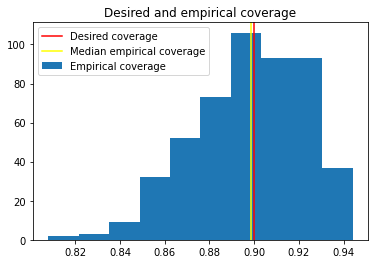

In [33]:
desired_cov = 0.9
empirical_cov_sample = sample_empirical_coverage_cqr(nonlinear_data_generator, 1500, 500, desired_cov)

fig, ax = plt.subplots()
ax.hist(empirical_cov_sample, label='Empirical coverage')
ax.axvline(desired_cov, label='Desired coverage', color='red')
ax.axvline(np.median(empirical_cov_sample), label='Median empirical coverage', color='yellow')
ax.set_title("Desired and empirical coverage")
ax.legend()
fig.show()